In [1]:
import os

import numpy as np
import pandas as pd
import scipy.linalg as LA
import scipy.sparse as sps

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

# %matplotlib notebook

## Reading the datasets

In [2]:
def fcps_reader(name, data_dir='../input/FCPS'):
    points = pd.read_csv(f"{data_dir}/{name}.lrn", sep='\t', comment='%', index_col=0, header=None)
    labels = pd.read_csv(f"{data_dir}/{name}.cls", sep='\t', comment='%', index_col=0, header=None)
    
    points = points.rename(columns= lambda x: f"x{x}")
    labels = labels.rename(columns={labels.columns[0]: 'y'})
    
    return pd.concat([points, labels], axis=1)

In [3]:
fcps_datasets = ['Atom', 'Chainlink', 'GolfBall', 'Hepta', 'Tetra']

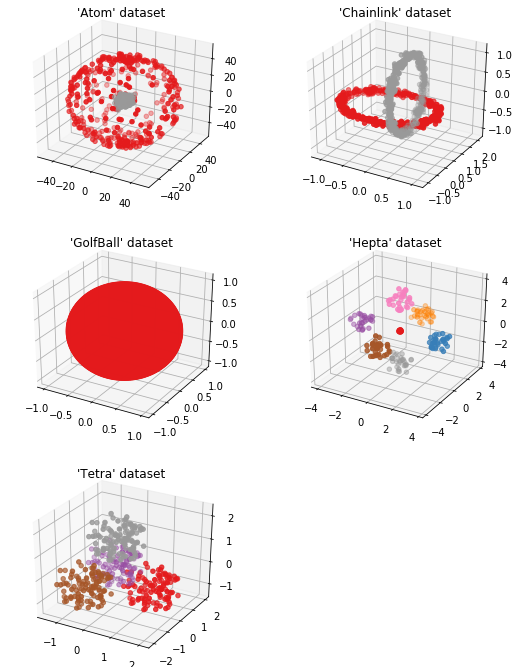

In [4]:
fig = plt.figure(figsize=(9,12))
for i, name in enumerate(fcps_datasets):
    data = fcps_reader(name)
    ax = fig.add_subplot(3,2,i+1, projection='3d')
    ax.scatter(data.x1, data.x2, data.x3, c=data.y, cmap='Set1')
    ax.set_title(f"{name!r} dataset")

In [5]:
data = fcps_reader('Tetra')
data.head()

x1        x2        x3  y
0                                 
1  1.295428  0.050829 -0.385217  1
2  1.409178 -0.035191 -0.251980  1
3  1.096803  0.246365 -0.415011  1
4  1.463328  0.265354 -0.513488  1
5  1.603284  0.080577 -0.470257  1

In [6]:
data.y.value_counts().sort_index()

1    100
2    100
3    100
4    100
Name: y, dtype: int64

In [7]:
X = data.iloc[:, :-1].values
y = data.y

In [8]:
n_neighbors=9

## Dimensionality reduction methods

In [9]:
%%time
pca_embed = PCA(n_components=2).fit_transform(X)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.45 ms


In [10]:
%%time
lle_embed = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 53.3 ms


In [11]:
%%time
isomap_embed = Isomap(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 62.5 ms, sys: 31.2 ms, total: 93.8 ms
Wall time: 102 ms


In [12]:
%%time
mds_embed = MDS(n_components=2).fit_transform(X)

CPU times: user 5.55 s, sys: 4.98 s, total: 10.5 s
Wall time: 1.44 s


### Auto-encoder

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self, encode_sizes, decode_sizes=None):
        super(AutoEncoder, self).__init__()
        if decode_sizes is None:
            decode_sizes = encode_sizes[::-1]
        
        self.encoder = AutoEncoder.make_sequential(encode_sizes)
        self.decoder = AutoEncoder.make_sequential(decode_sizes)
    
    @staticmethod
    def make_sequential(layer_sizes):
        n = len(layer_sizes)
        ls = layer_sizes
        # create fully connected layers with ReLU activations
        layers = [(nn.Linear(ls[i-1], ls[i]), nn.ReLU()) for i in range(1,n-1)]
        # unwrap tuples
        layers = [fn for layer in layers for fn in layer]
        # add the last layer
        layers += [nn.Linear(ls[n-2], ls[n-1])]
        # transform to sequential
        return nn.Sequential(*layers)
        

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    

In [14]:
num_epochs = 100

ae = AutoEncoder([3,3,2])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=.01, weight_decay=1e-5)

inputs = torch.tensor(X, dtype=torch.float)

for epoch in range(num_epochs):
    # ===================forward=====================
    enc, dec = ae(inputs)
    loss = criterion(dec, inputs)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [15]:
with torch.no_grad():
    ae_embed = ae.encode(inputs).numpy()

### Plotting the results of the dimensionality reduction methods

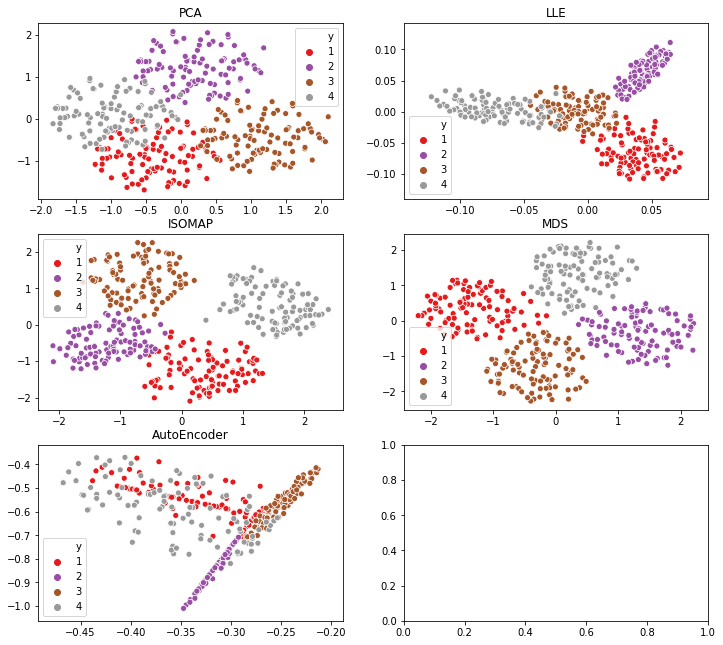

In [16]:
dimred = [("PCA", pca_embed), ("LLE", lle_embed), ("ISOMAP", isomap_embed),
          ("MDS", mds_embed), ("AutoEncoder", ae_embed)]

fig, axs = plt.subplots(3,2, figsize=(12,11))

for ax, (redname, redvals) in zip(axs.flat, dimred):
    sns.scatterplot(redvals[:, 0], redvals[:, 1], hue=y, ax=ax, palette='Set1', legend='full')
    ax.set_title(redname)

### LLE implementation

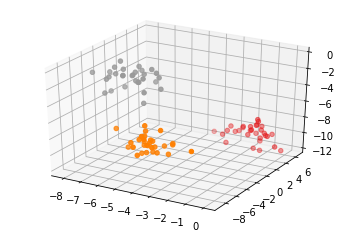

In [17]:
from sklearn.datasets import make_blobs
X_t, y_t = make_blobs(n_samples=90, n_features=3, centers=3, random_state=1)

ax = plt.axes(projection='3d')

ax.scatter(X_t[:,0], X_t[:,1], X_t[:,2], c=y_t, cmap='Set1')

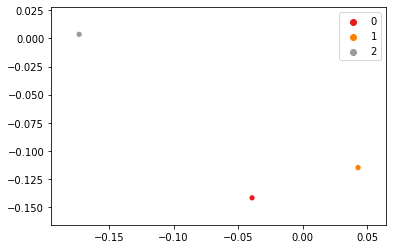

In [18]:
lleX = LocallyLinearEmbedding(n_neighbors=5).fit_transform(X_t)
sns.scatterplot(lleX[:,0], lleX[:,1],hue=y_t, palette='Set1')

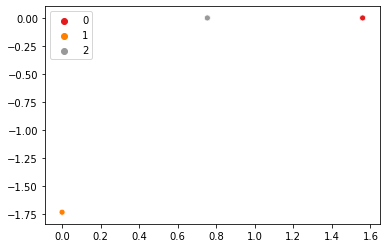

In [25]:
class LLE:
    def __init__(self, n_neighbors=5, d=2, reg=1E-3):
        self.reg = reg
        self.k = n_neighbors
        self.d = d
        
    def fit(self, X):
        n, r = X.shape

        # Step 1: compute pairwise distances
        knn = NearestNeighbors().fit(X)
        neighborhood = knn.kneighbors(X, n_neighbors=self.k+1, return_distance=False)[:, 1:]

        # Step 2: solve for the reconstruction weights W
        W = np.zeros((n,n))
        ones = np.ones(self.k)

        for i in range(n):
            nbrs = neighborhood[i,:]
            z = X[nbrs, :] - X[i, :]
            C = z @ z.T

            # regularization
            trace = float(C.trace())
            C.flat[::self.k+1] += self.reg * trace if trace > 0 else self.reg

    #         W[i, nbrs] = LA.pinv(C) @ ones
            W[i, nbrs] = LA.solve(C, ones)

    #     print(np.round(W, 2))
        W = W / W.sum(axis=1)[:, np.newaxis]


        # Step 3: compute the embedding from the eigenvectors
        W.flat[::W.shape[0]+1] -= 1 # W - I
        # calculate the embeddings
        u, w, v = LA.svd(W)

        idx = np.argsort(w)[1:(self.d+1)]
        Y = v.T[:, idx] * n**.5
        
        self.S_ = W
        self.B_ = Y

        return self
    
    def fit_transform(self, X):
        self.fit(X)
        return self.S_, self.B_
    
#     def transform


S, mylleX = LLE(n_neighbors=5).fit_transform(X_t)

sns.scatterplot(mylleX[:,0], mylleX[:,1],hue=y_t, palette='Set1')

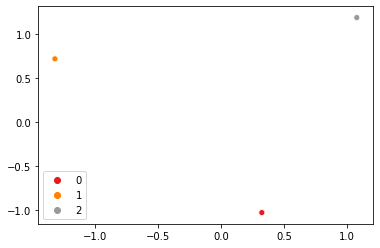

In [21]:
def sparse_LLE(X, k=9, d=2, reg=1E-3):
    n, r = X.shape

    # Step 1: compute pairwise distances
    knn = NearestNeighbors().fit(X)
    neighborhood = knn.kneighbors(X, n_neighbors=k+1, return_distance=False)[:, 1:]
    
    # Step 2: solve for the reconstruction weights W
    W = np.zeros((n,n))
    ones = np.ones(k)
    
    rows = np.empty((n*k,), dtype=int)
    cols = np.empty((n*k,), dtype=int)
    vals = np.empty((n*k,))
    for i in range(n):
        nbrs = neighborhood[i,:]
        z = X[nbrs, :] - X[i, :]
        C = z @ z.T
        
        # regularization
        trace = float(C.trace())
        C.flat[::k+1] += reg * trace if trace > 0 else reg
        
        values = LA.solve(C, ones)
        
        s,e = i*k, (i+1)*k
        vals[s:e] = values
        rows[s:e] = np.repeat(i, k)
        cols[s:e] = nbrs

    W = sps.csr_matrix((vals, (rows, cols)), shape=(n,n))
#     print(np.round(W.toarray(), 2))
    
    w_sum = W.sum(axis=1).A.ravel()
    w_sum_inv = sps.diags(1/w_sum)
    
    W = w_sum_inv @ W

       
    # Step 3: compute the embedding from the eigenvectors
    I = sps.eye(n)
    W = W - I
    # calculate the embeddings
    u, w, v = sps.linalg.svds(W, k=n-1, which='LM')
#     u, w, v = LA.svd(W.toarray())
#     w, v = sps.linalg.eigsh(W.T @ W, k=d+1, which='SM', sigma=0)
#     print(w.shape, v.shape)
#     v = v.T
    
    idx = np.argsort(w)[:d]
    Y = v.T[:, idx] * n**.5
#     print(type(W))    
    return W.toarray(), Y


S, mylleX = sparse_LLE(X_t, k=5)

sns.scatterplot(mylleX[:,0], mylleX[:,1],hue=y_t, palette='Set1')

In [ ]:
class AE_LLE:
    
    def __init__(self, ae, n_neighbors, n_dim, l):
        self.ae = ae
        self.lle = LLE(n_neighbors, n_dim)
        
    def train(self, X):
        pass

In [22]:
def loss(X, encoded, decoded, S, l):
    """Computes the autoencoder loss
    loss = ||X - decoded||^2 + l * ||encoded - S*encoded||^2
    the autoencoder should keep as much information while also
    keeping the neighborhoods as separate as possible // could be better phrased
    """
    sim = X - decoded # how similar the result is to the input
    sep = encoded - S @ encoded # how well separated the embedding is
    
    return (sim ** 2).sum() + l * (sep ** 2).sum()

In [23]:
fcps_datasets

['Atom', 'Chainlink', 'GolfBall', 'Hepta', 'Tetra']

100%|██████████| 50/50 [00:02<00:00, 24.23it/s]


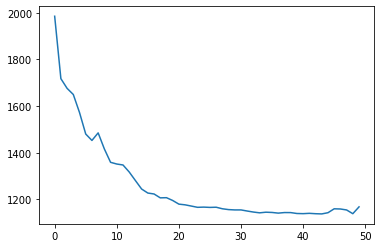

In [26]:
# %%prun -s time -l 20
train = fcps_reader(fcps_datasets[-2])
X_train = train.iloc[:, :-1].values
y_train = train.y

# X_train = X_t
# y_train = y_t 

num_epochs = 50

# print(X_train.shape, y_train.shape)

ae = AutoEncoder([3,3,2])
optimizer = torch.optim.Adam(ae.parameters(), lr=.1, weight_decay=1e-5)
inputs = torch.tensor(X_train, dtype=torch.float)

n_neigh = 9

losses = []

for epoch in tqdm(range(num_epochs)):
    # encode
    enc, dec = ae(inputs)
    # compute
    X_enc = enc.detach().numpy()
    S, _ = LLE(n_neigh, X_enc.shape[1]).fit_transform(X_enc)
    
    cost = loss(inputs, enc, dec, torch.Tensor(S), l=1)
#     print(f"Loss:\t{cost.item():.3f}")
    losses.append(cost.item())
    
    # update autoencoder weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
plt.plot(losses)

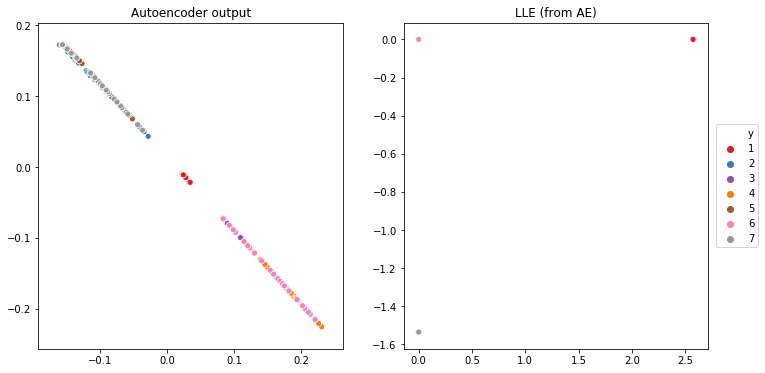

In [28]:
with torch.no_grad():
    ae_lle_embed = ae.encode(inputs).numpy()

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(ae_lle_embed[:,0], ae_lle_embed[:,1],hue=y_train, palette='Set1', ax=axs[0], legend=False)
axs[0].set_title('Autoencoder output')

_, Y = LLE(n_neigh, ae_lle_embed.shape[1]).fit_transform(ae_lle_embed)
sns.scatterplot(Y[:,0], Y[:,1],hue=y_train, palette='Set1', ax=axs[1], legend='full')
axs[1].set_title('LLE (from AE)')
axs[1].legend(loc='center left', bbox_to_anchor=(1.01,.5))

## Datasets
MNIST and USPS can be directly used from `torchvision.datasets`